In [73]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import sys
import string

from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
import os
from gensim import corpora, models
import json
import pandas as pd
from sklearn.datasets import load_svmlight_file

from sklearn import  svm,neighbors
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import pandas 
import numpy as np
from collections import defaultdict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample


The yelp dataset has a business json file, and reviews json file. We will import them as lists of dictionaries with json.loads and then convert to pandas to sort the data

In [2]:
busfile = '/home/rungsunan/data/yelp/business.json'

In [3]:
business_df = pd.read_json('/home/rungsunan/data/yelp/business.json',lines=True)

The review file is too big for pd.read_json. Let's load the file into an array with json.loads instead

In [4]:
reviewfile = '/home/rungsunan/data/yelp/review.json'

In [5]:
reviews = []
with open(reviewfile) as data_file:    
    for line in data_file:
        reviews.append(json.loads(line))

In [6]:
reviews[0]

{'review_id': 'Q1sbwvVQXV2734tPgoKj4Q',
 'user_id': 'hG7b0MtEbXx5QzbzE6C_VA',
 'business_id': 'ujmEBvifdJM6h6RLv4wQIg',
 'stars': 1.0,
 'useful': 6,
 'funny': 1,
 'cool': 0,
 'text': 'Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.',
 'date': '2013-05-07 04:34:36'}

In [7]:
business_df = business_df[['business_id','categories']]

The categories key in the business dictionary contains a list including cuisine type. We will convert these to pandas dataframes and match 'Chinese' and 'Italian' businesses to the text from the reviews.

In [8]:
business_df.head()

,business_id,categories
0,1SWheh84yJXfytovILXOAQ,"Golf, Active Life"
1,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported..."
2,gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese"
3,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services"
4,HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi..."


In [9]:
business_ci = business_df[business_df['categories'].str.contains("Chinese|Italian")==True]


In [10]:
business_ci.head()

,business_id,categories
1,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported..."
13,fweCYi8FmbJXHCqLnwuk8w,"Italian, Restaurants, Pizza, Chicken Wings"
17,PZ-LZzSlhSe9utkQYU8pFg,"Restaurants, Italian"
35,BvYU3jvGd0TJ7IyZdfiN2Q,"Sandwiches, Italian, American (Traditional), A..."
45,e_EMySqP0uwlVZfd8mRaaQ,"Chinese, Dim Sum, Restaurants"


In [11]:
business_ci.loc[business_ci['categories'].str.contains("Chinese"), "cuisine"] = "Chinese"
business_ci.loc[business_ci['categories'].str.contains("Italian"), "cuisine"] = "Italian"

/home/rungsunan/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/rungsunan/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/rungsunan/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

In [12]:
business_df = business_ci[['business_id','cuisine']]

In [13]:
business_df.head()

,business_id,cuisine
1,QXAEGFB4oINsVuTFxEYKFQ,Chinese
13,fweCYi8FmbJXHCqLnwuk8w,Italian
17,PZ-LZzSlhSe9utkQYU8pFg,Italian
35,BvYU3jvGd0TJ7IyZdfiN2Q,Italian
45,e_EMySqP0uwlVZfd8mRaaQ,Chinese


In [14]:
print('Number of Italian or Chinese Restaurants: ' + 
      str(len((business_df[(business_df.cuisine == 'Italian') | (business_df.cuisine == 'Chinese')]))))
print('Number of Italian Restaurants: ' + str(len((business_df[(business_df.cuisine == 'Italian')]))))
print('Number of Chinese Restaurants: ' + str(len((business_df[(business_df.cuisine == 'Chinese')]))))

Number of Italian or Chinese Restaurants: 9349
Number of Italian Restaurants: 4716
Number of Chinese Restaurants: 4633


In [15]:
reviews_df = pd.DataFrame.from_dict(reviews)
reviews_df.head()


,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


We only are interested in the businessID and the text of the reviews

In [16]:
reviews_df = reviews_df[['business_id','text']]
reviews_df.head()

,business_id,text
0,ujmEBvifdJM6h6RLv4wQIg,Total bill for this horrible service? Over $8G...
1,NZnhc2sEQy3RmzKTZnqtwQ,I *adore* Travis at the Hard Rock's new Kelly ...
2,WTqjgwHlXbSFevF32_DJVw,I have to say that this office really has it t...
3,ikCg8xy5JIg_NGPx-MSIDA,Went in for a lunch. Steak sandwich was delici...
4,b1b1eb3uo-w561D0ZfCEiQ,Today was my second out of three sessions I ha...


In [17]:
final_df =  pd.merge(business_df,reviews_df,on='business_id')
final_df.head(100)

,business_id,cuisine,text
0,QXAEGFB4oINsVuTFxEYKFQ,Chinese,My girlfriend and I went for dinner at Emerald...
1,QXAEGFB4oINsVuTFxEYKFQ,Chinese,We've always been there on a Sunday so we were...
2,QXAEGFB4oINsVuTFxEYKFQ,Chinese,"***No automatic doors, not baby friendly!*** I..."
3,QXAEGFB4oINsVuTFxEYKFQ,Chinese,"Horrible service,\nI went there tonight with m..."
4,QXAEGFB4oINsVuTFxEYKFQ,Chinese,One of the gauges of a good Chinese restaurant...
5,QXAEGFB4oINsVuTFxEYKFQ,Chinese,"I've been a frequent at this place for years, ..."
6,QXAEGFB4oINsVuTFxEYKFQ,Chinese,We chose this restaurant for our Chinese New Y...
7,QXAEGFB4oINsVuTFxEYKFQ,Chinese,I went at 230 on a Monday. It was dimsum \n\nI...
8,QXAEGFB4oINsVuTFxEYKFQ,Chinese,My family and I were at Emerald yesterday duri...
9,QXAEGFB4oINsVuTFxEYKFQ,Chinese,"Because we are in Mississauga, I think this pl..."


In [18]:
print('Number of Italian Restaurant reviews: ' + str(len((final_df[(final_df.cuisine == 'Italian')]))))
print('Number of Chinese Restaurant reviews: ' + str(len((final_df[(final_df.cuisine == 'Chinese')]))))

Number of Italian Restaurant reviews: 392125
Number of Chinese Restaurant reviews: 262695


For text analysis we use a code for the cuisine type, and make all of the text lowercase for stemming.

In [19]:
final_df["cuisine_code"] = np.where(final_df["cuisine"].str.contains("Italian"), 1,-1)
final_df['text'] = final_df['text'].str.lower()
final_df.head(10)


,business_id,cuisine,text,cuisine_code
0,QXAEGFB4oINsVuTFxEYKFQ,Chinese,my girlfriend and i went for dinner at emerald...,-1
1,QXAEGFB4oINsVuTFxEYKFQ,Chinese,we've always been there on a sunday so we were...,-1
2,QXAEGFB4oINsVuTFxEYKFQ,Chinese,"***no automatic doors, not baby friendly!*** i...",-1
3,QXAEGFB4oINsVuTFxEYKFQ,Chinese,"horrible service,\ni went there tonight with m...",-1
4,QXAEGFB4oINsVuTFxEYKFQ,Chinese,one of the gauges of a good chinese restaurant...,-1
5,QXAEGFB4oINsVuTFxEYKFQ,Chinese,"i've been a frequent at this place for years, ...",-1
6,QXAEGFB4oINsVuTFxEYKFQ,Chinese,we chose this restaurant for our chinese new y...,-1
7,QXAEGFB4oINsVuTFxEYKFQ,Chinese,i went at 230 on a monday. it was dimsum \n\ni...,-1
8,QXAEGFB4oINsVuTFxEYKFQ,Chinese,my family and i were at emerald yesterday duri...,-1
9,QXAEGFB4oINsVuTFxEYKFQ,Chinese,"because we are in mississauga, i think this pl...",-1


In [20]:
outcome_reviews = list(zip(final_df.cuisine_code,final_df.text))
print("Total number of Chinese/Italian reviews: " + str(len(outcome_reviews)))
outcome_reviews[0]

Total number of Chinese/Italian reviews: 654820


(-1,
 'my girlfriend and i went for dinner at emerald chinese after a thursday night workout.\n\nwe arrived around 7:30pm and were seated after a short wait.  after browsing the menu and a brief discussion with our waiter, we ordered seafood noodles and a 3 item mix meat plate (bbq pork, chicken, and duck)\n\nthe food came soon thereafter and it was hot and delicious.  there was large portions and lots of seafood in the seafood noodles and the mix meat plate came with good cuts of meat and the correct sauces.\n\nafter the meal, we received fortune cookies for dessert.\n\n\nfood\nthe food was good quality.  ingredients tasted fresh and dishes tasted well made.  food is above average but nothing stood out even though i was quite hungry.\n\nprice\nprice is high in comparative to other chinese cuisine, and comparable to large western restaurant chains.\n\nservice:\nthe service is average to slightly below average.  a common malaise of chinese restaurants is poor service where the waiter/wa

In [21]:
tokenizer = RegexpTokenizer(r'\s+', gaps=True)

# create English stop words list
en_stop = set(get_stop_words('en'))
#print(en_stop)
# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

from the review text, we remove the punctuation and stop words and turn the words in the reviews to the stemmed versions(eg tasting or tasted into tast). The array will have the cuisinetype and stemmed review text

In [22]:
texts = []
punctuation_string = '\"?!@#$%^&*()\';:+,/.-|~=\\'
table = str.maketrans(dict.fromkeys(punctuation_string))
# loop through document list
for index, row in final_df.iterrows():
    # clean and tokenize document string
    raw = row.text
    raw = raw.translate(table)
    tokens = tokenizer.tokenize(raw)
    
    # remove stop words from tokens
    stopped_tokens = [j for j in tokens if not j in en_stop]
    # print(tokens)
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(k) for k in stopped_tokens]
    
    # add tokens to list
    texts.append((final_df.cuisine_code[index], stemmed_tokens))

print("doc_set done!")
os.system('say "doc set done"')

doc_set done!


256

In [23]:
texts[1]

(-1,
 ['weve',
  'alway',
  'sunday',
  'hope',
  'saturday',
  'dim',
  'sum',
  'less',
  'busi',
  'luck',
  'surpris',
  'dish',
  'cold',
  'pack',
  'understand',
  'empti',
  'cart',
  'werent',
  'circul',
  'everi',
  'tabl',
  'full',
  'took',
  'get',
  'drink',
  'item',
  'napkin',
  'dish',
  'qualiti',
  'visit',
  'accept'])

In [24]:
([x[1] for x in texts[:10]])

[['girlfriend',
  'went',
  'dinner',
  'emerald',
  'chines',
  'thursday',
  'night',
  'workout',
  'arriv',
  'around',
  '730pm',
  'seat',
  'short',
  'wait',
  'brows',
  'menu',
  'brief',
  'discuss',
  'waiter',
  'order',
  'seafood',
  'noodl',
  '3',
  'item',
  'mix',
  'meat',
  'plate',
  'bbq',
  'pork',
  'chicken',
  'duck',
  'food',
  'came',
  'soon',
  'thereaft',
  'hot',
  'delici',
  'larg',
  'portion',
  'lot',
  'seafood',
  'seafood',
  'noodl',
  'mix',
  'meat',
  'plate',
  'came',
  'good',
  'cut',
  'meat',
  'correct',
  'sauc',
  'meal',
  'receiv',
  'fortun',
  'cooki',
  'dessert',
  'food',
  'food',
  'good',
  'qualiti',
  'ingredi',
  'tast',
  'fresh',
  'dish',
  'tast',
  'well',
  'made',
  'food',
  'averag',
  'noth',
  'stood',
  'even',
  'though',
  'quit',
  'hungri',
  'price',
  'price',
  'high',
  'compar',
  'chines',
  'cuisin',
  'compar',
  'larg',
  'western',
  'restaur',
  'chain',
  'servic',
  'servic',
  'averag',
  

In [25]:
texts_dictionary = corpora.Dictionary([x[1] for x in texts])
print("there are: " + str(len(texts)) + " review documents in the dictionary")
print("dictionary done!")
os.system('say "Finished dictionary"')

there are: 654820 review documents in the dictionary
dictionary done!


256

In [26]:
def make_corpus(texts_tuple,dictionary):
    text_list = [x[1] for x in texts_tuple]
    return  [dictionary.doc2bow(text) for text in text_list]

#corpus_p = make_corpus(texts_learn_p)
#corpus_2p = make_corpus(texts_learn_2p)
#corpus_all = make_corpus(texts_learn_all)

In [27]:
def create_sample_set(text_tuple,set_size):
    temp_texts = resample(text_tuple, replace = False, n_samples = set_size)
    return(temp_texts)

In [28]:
texts_outcome_p1k = create_sample_set(texts,1000)
texts_outcome_p3k = create_sample_set(texts,3000)
texts_outcome_p7k = create_sample_set(texts,7000)
texts_outcome_p10k = create_sample_set(texts,10000)
texts_outcome_p50k = create_sample_set(texts,50000)
texts_outcome_p100k = create_sample_set(texts,100000)
texts_outcome_all = create_sample_set(texts,len(texts))

In [29]:
temp_corpus = make_corpus(texts_outcome_p1k,texts_dictionary)

In [30]:
temp_corpus_50k = make_corpus(texts_outcome_p50k,texts_dictionary)

In [31]:
temp_model = models.LdaMulticore(corpus=temp_corpus,num_topics=5,id2word=texts_dictionary, passes=10)

In [ ]:
temp_model_50k = models.LdaMulticore(corpus=temp_corpus_50k,num_topics=5,id2word=texts_dictionary, passes=10)

In [32]:
temp_model_corpus = temp_model[temp_corpus]
temp_outcomes = [x[0] for x in texts_outcome_p1k]

In [ ]:
temp_model_corpus_50k = temp_model_50k[temp_corpus_50k]
temp_outcomes_50k = [x[0] for x in texts_outcome_p50k]

In [33]:
model_dict["lda_model_p1k_5topics"] = {"model": temp_model,"model_corpus": temp_model_corpus, "outcomes":temp_outcomes}

NameError: name 'model_dict' is not defined

In [ ]:
model_dict["lda_model_p50k_5topics"] = {"model": temp_model_50k,"model_corpus_50k": temp_model_corpus_50k, "outcomes":temp_outcomes_50k}

In [44]:
    print(model_dict)

NameError: name 'model_dict' is not defined

In [45]:
model_dict = dict()

In [57]:
model_dict = dict()

def make_model_and_corpus(texts_tuple,num_top, num_pass, model_name,dictionary):
    text_list = [x[1] for x in texts_tuple]
    temp_corpus = make_corpus(texts_tuple,dictionary)
    print(model_name)
    temp_model = models.LdaMulticore(corpus=temp_corpus,num_topics=num_top,id2word=dictionary, passes=num_pass)
    temp_model_corpus = temp_model[temp_corpus]
    temp_outcomes = [x[0] for x in texts_tuple]
    model_dict[model_name] = {"model": temp_model,"model_corpus": temp_model_corpus, "outcomes":temp_outcomes}
    print(model_dict)
    #model_dict[model_name] = {"model": models.ldamodel.LdaModel(corpus_name, num_topics=num_top, id2word = dictionary, passes=pass_num)}
    
    #modelname.save("/Users/rungsunan/spyder/yelpproject/" + str(modelname))
    #print(modelname + " for " + corpus + " complete!")
       
#make_model_and_corpus(corpus_p,2,5,"lda_model_corpus_p")
#make_model_and_corpus(corpus_2p,2,5,"lda_model_corpus_2p")
#make_model_and_corpus(corpus_all,2,5,"lda_model_corpus_all")
def save_model_and_corpus(modelname):
    model_dict[modelname]['model'].save('/home/rungsunan/code/finalADM'+ modelname + '.model')
    corpora.SvmLightCorpus.serialize('/home/rungsunan/code/finalADM'+ modelname + '_corpus.svmlight', model_dict[modelname]['model_corpus'],labels=model_dict[modelname]['outcomes'])


def load_ldamodel(modelname):
    print(modelname)
    X_temp, y_temp = load_svmlight_file("/home/rungsunan/code/finalADM" + modelname)
    return (X_temp,y_temp)


def train_svm(X, y):
    """
    Create and train the Support Vector Machine.
    """
    clf = svm.SVC(kernel='linear')
    clf.fit(X, y)
    return clf

def histo_corpus(modelname):
    histo = []
    corpus = model_dict[modelname]['model_corpus']
    for doc in corpus:
        for i in range(len(doc)):
            if doc[i][1] > .1:
                histo.append(doc[i][0])
    return histo


def best_topics (texts_tuple, dictionary):
    grid = defaultdict(list)
    param_list = []
    perplex_list = []
    perword_list = []
    text_list = [x[1] for x in texts_tuple]
    temp_corpus = [dictionary.doc2bow(text) for text in text_list]
    number_of_words = sum(cnt for document in temp_corpus for _, cnt in document)
    parameter_list = [2,3,4,5,10,30,75,120]
    for parameter_value in parameter_list:      
        print ("starting pass for parameter_value = %.3f" % parameter_value)
        model = models.LdaMulticore(corpus=temp_corpus, workers=None, id2word=dictionary, num_topics=parameter_value, passes=4, iterations=20)
        perplex = model.bound(temp_corpus) # this is model perplexity not the per word perplexity
        print ("Total Perplexity: %s" % perplex)
        param_list.append(parameter_value)
        perplex_list.append(perplex)
        grid[parameter_value].append(perplex)

    
        per_word_perplex = np.exp2(-perplex / number_of_words)
        perword_list.append(per_word_perplex)
        print ("Per-word Perplexity: %s" % per_word_perplex)
        grid[parameter_value].append(per_word_perplex)
        #model.save(data_path + 'ldaMulticore_i10_T' + str(parameter_value) + '_training_corpus.lda')

    for numtopics in parameter_list:
        print (numtopics, '\t',  grid[numtopics])
    df = pandas.DataFrame(grid)
    ax = plt.figure(figsize=(7, 4), dpi=300).add_subplot(111)
    df.iloc[1].transpose().plot(ax=ax,  color="#254F09")
    plt.xlim(parameter_list[0], parameter_list[-1])
    plt.ylabel('Perplexity')
    plt.xlabel('topics')
    plt.title('')
    plt.show()
    #df.to_pickle(data_path + 'gensim_multicore_i10_topic_perplexity.df')


In [48]:
def best_topics (texts_tuple, dictionary):
    grid = defaultdict(list)
    param_list = []
    perplex_list = []
    perword_list = []
    text_list = [x[1] for x in texts_tuple]
    temp_corpus = [dictionary.doc2bow(text) for text in text_list]
    number_of_words = sum(cnt for document in temp_corpus for _, cnt in document)
    parameter_list = [2,3,4,5,10,30,75,120]
    for parameter_value in parameter_list:      
        print ("starting pass for parameter_value = %.3f" % parameter_value)
        model = models.LdaMulticore(corpus=temp_corpus, workers=3, id2word=dictionary, num_topics=parameter_value, passes=4, iterations=20)
        perplex = model.bound(temp_corpus) # this is model perplexity not the per word perplexity
        print ("Total Perplexity: %s" % perplex)
        param_list.append(parameter_value)
        perplex_list.append(perplex)
        grid[parameter_value].append(perplex)

    
        per_word_perplex = np.exp2(-perplex / number_of_words)
        perword_list.append(per_word_perplex)
        print ("Per-word Perplexity: %s" % per_word_perplex)
        grid[parameter_value].append(per_word_perplex)
        #model.save(data_path + 'ldaMulticore_i10_T' + str(parameter_value) + '_training_corpus.lda')

    for numtopics in parameter_list:
        print (numtopics, '\t',  grid[numtopics])
    df = pandas.DataFrame(grid)
    ax = plt.figure(figsize=(7, 4), dpi=300).add_subplot(111)
    df.iloc[1].transpose().plot(ax=ax,  color="#254F09")
    plt.xlim(parameter_list[0], parameter_list[-1])
    plt.ylabel('Perplexity')
    plt.xlabel('topics')
    plt.title('')
    plt.show()

In [58]:
model_dict["lda_model_p1k_5topics"] = {"model": temp_model,"model_corpus": temp_model_corpus, "outcomes":temp_outcomes}

In [50]:
def create_sample_set(text_tuple,set_size):
    temp_texts = resample(text_tuple, replace = False, n_samples = set_size)
    return(temp_texts)

In [51]:
texts_outcome_p100 = create_sample_set(texts,100)

In [52]:
texts_outcome_p100[9]


(1,
 ['definit',
  'worthi',
  '5',
  'star',
  'good',
  'servic',
  'quick',
  'seat',
  'food',
  'unbeliev',
  'got',
  'spici',
  'sausag',
  'pasta',
  'garlic',
  'shrimp',
  'linguin',
  'ive',
  'never',
  'better',
  'pasta',
  'anywher',
  'els',
  'honestli',
  'simpli',
  'incred',
  'dont',
  'think',
  'just',
  'go'])

In [53]:
texts_outcome_p100k = create_sample_set(texts,100000)

In [54]:
texts_outcome_p1k = create_sample_set(texts,1000)
texts_outcome_p3k = create_sample_set(texts,3000)
texts_outcome_p7k = create_sample_set(texts,7000)
texts_outcome_p10k = create_sample_set(texts,10000)
texts_outcome_p50k = create_sample_set(texts,50000)
texts_outcome_p100k = create_sample_set(texts,100000)
texts_outcome_all = create_sample_set(texts,len(texts))

starting pass for parameter_value = 2.000
Total Perplexity: -57468.4454934597
Per-word Perplexity: 2745.5268811859746
starting pass for parameter_value = 3.000
Total Perplexity: -55366.9587598443
Per-word Perplexity: 2055.3377327407607
starting pass for parameter_value = 4.000
Total Perplexity: -55109.19817137718
Per-word Perplexity: 1983.6273369016617
starting pass for parameter_value = 5.000
Total Perplexity: -53895.91914051771
Per-word Perplexity: 1678.276476293839
starting pass for parameter_value = 10.000
Total Perplexity: -57371.79443693161
Per-word Perplexity: 2709.2094519164166
starting pass for parameter_value = 30.000
Total Perplexity: -57972.0078933239
Per-word Perplexity: 2942.7703217607204
starting pass for parameter_value = 75.000
Total Perplexity: -63495.08290231228
Per-word Perplexity: 6298.3919320670975
starting pass for parameter_value = 120.000
Total Perplexity: -70009.03224927187
Per-word Perplexity: 15452.259203085134
2 	 [-57468.4454934597, 2745.5268811859746]
3 	

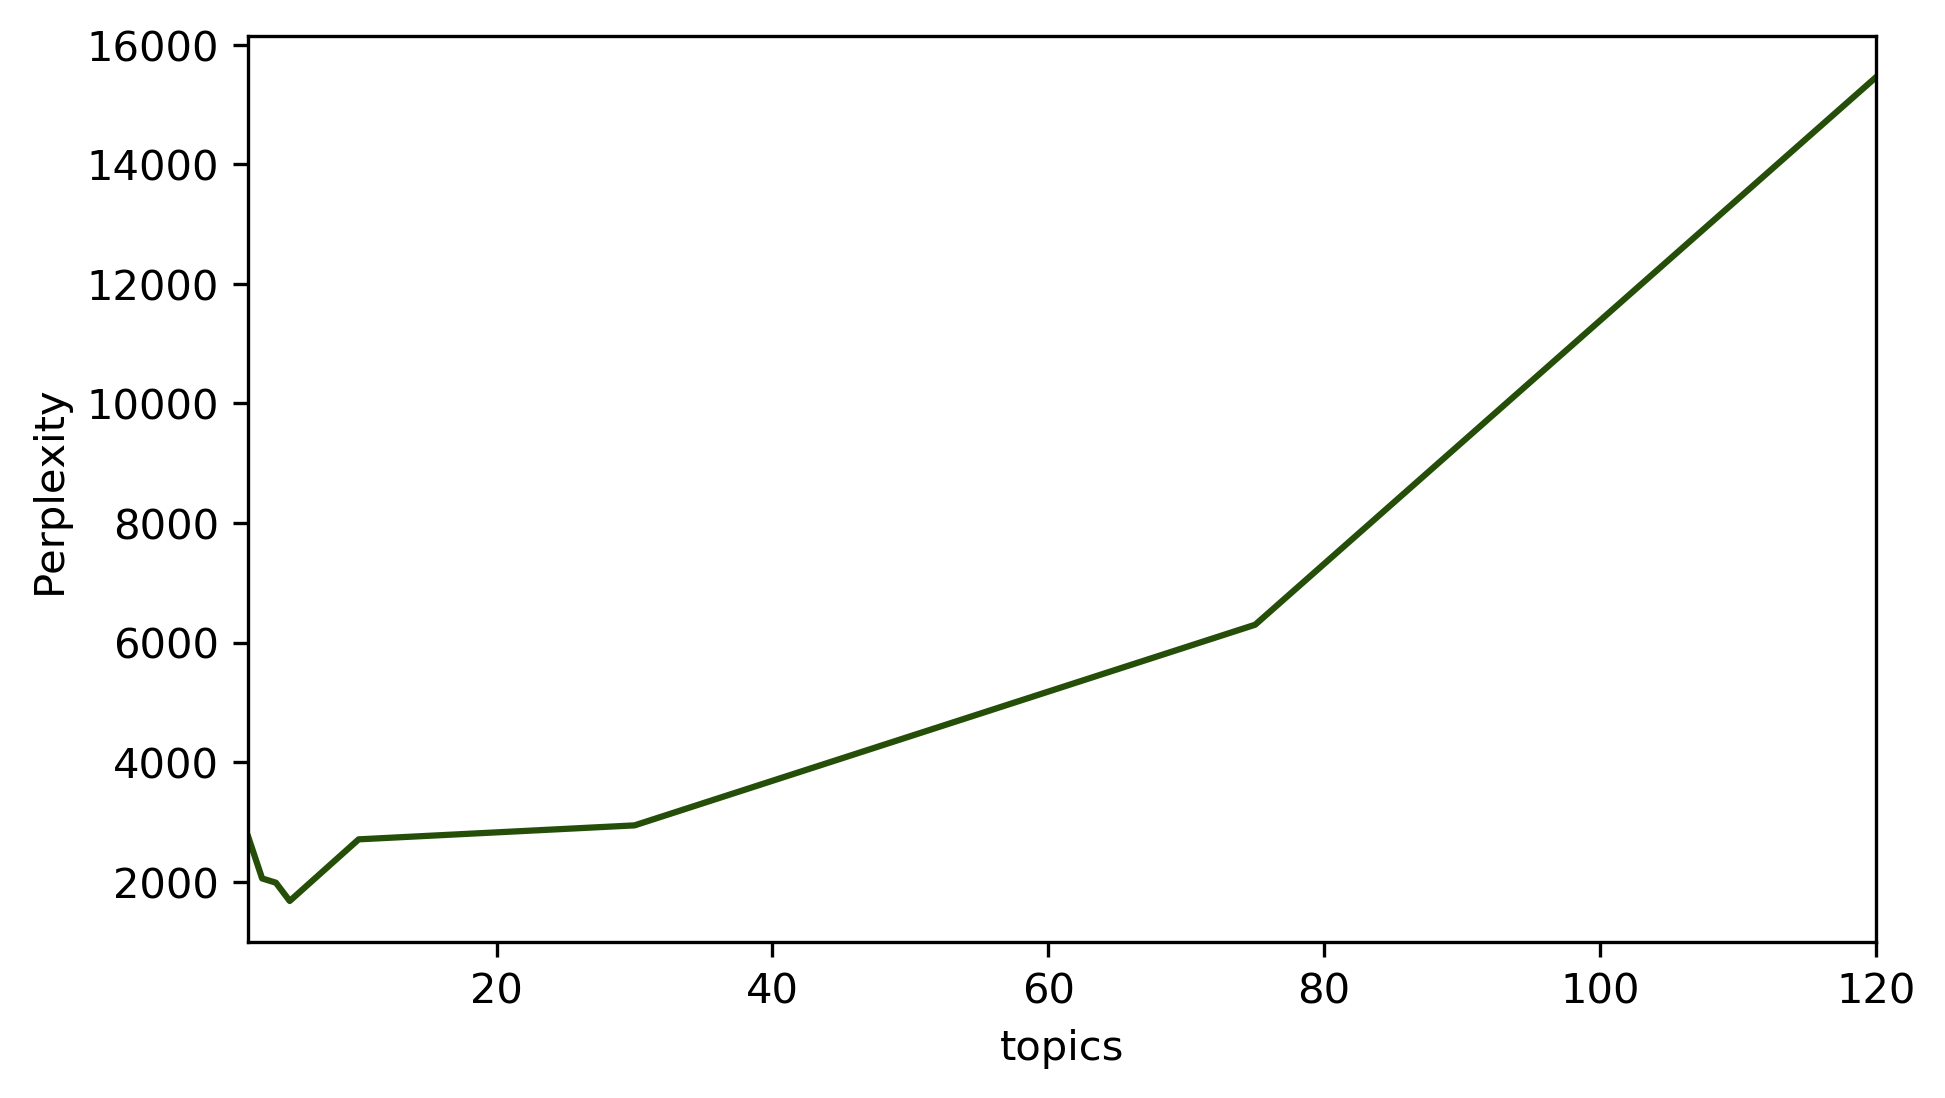

In [55]:
best_topics(texts_outcome_p100, texts_dictionary)

In [ ]:
best_topics(texts_outcome_p1k, texts_dictionary)

starting pass for parameter_value = 2.000
Total Perplexity: -530311.2561215162
Per-word Perplexity: 651.8136500181186
starting pass for parameter_value = 3.000
Total Perplexity: -525869.8186382055
Per-word Perplexity: 617.3831024569306
starting pass for parameter_value = 4.000
Total Perplexity: -533671.7043814659
Per-word Perplexity: 679.134572256671
starting pass for parameter_value = 5.000
Total Perplexity: -530370.2548951507
Per-word Perplexity: 652.2837075040695
starting pass for parameter_value = 10.000
Total Perplexity: -502771.8606635928
Per-word Perplexity: 465.5692184941301
starting pass for parameter_value = 30.000
Total Perplexity: -541390.9551348686
Per-word Perplexity: 746.3085776212278
starting pass for parameter_value = 75.000


In [ ]:
best_topics(texts_outcome_p100k, texts_dictionary)

In [ ]:
best_topics(texts_outcome_p1k, texts_dictionary)

In [ ]:
best_topics(texts_outcome_p3k,texts_dictionary)

In [ ]:
best_topics(texts_outcome_p10k,texts_dictionary)

In [ ]:
best_topics(texts_outcome_p50k,texts_dictionary)

In [ ]:
corpus_p100k = make_corpus(texts_outcome_p100k,texts_dictionary)

In [59]:
corpus_all = make_corpus(texts_outcome_all,texts_dictionary)
corpus_p10k = make_corpus(texts_outcome_p10k,texts_dictionary)
corpus_p50k = make_corpus(texts_outcome_p50k,texts_dictionary)

KeyboardInterrupt: 

In [ ]:
make_model_and_corpus(texts_outcome_p100,4  ,10,"lda_model_p100_4topics",texts_dictionary)

In [ ]:
model_dict

In [ ]:
make_model_and_corpus(texts_outcome_p1k,5  ,10,"lda_model_p1k_5topics",texts_dictionary)

In [ ]:
make_model_and_corpus(texts_outcome_p50k,5  ,10,"lda_model_p50k_5topics",texts_dictionary)

In [60]:
model_dict['lda_model_p50k_5topics']['outcomes']

KeyError: 'lda_model_p50k_5topics'

In [ ]:
save_model_and_corpus('lda_model_p100_4topics')

In [61]:
save_model_and_corpus('lda_model_p1k_5topics')

In [ ]:
save_model_and_corpus('lda_model_p50k_5topics')
#save_model_and_corpus('lda_model_p10k_2topics')
#save_model_and_corpus('lda_model_p10k_3topics')
#save_model_and_corpus('lda_model_p10k_10topics')


In [ ]:
model_dict.keys()

In [ ]:
(X_p100_4topics, y_p100_4topics) = load_ldamodel("lda_model_p100_4topics_corpus.svmlight")


In [62]:
(X_p1k_5topics, y_p1k_5topics) = load_ldamodel("lda_model_p1k_5topics_corpus.svmlight")

lda_model_p1k_5topics_corpus.svmlight


In [ ]:
#(X_all_2topics, y_all_2topics) = load_ldamodel("lda_model_all_2topics_corpus.svmlight")
#(X_p100k_5topics, y_p100k_5topics) = load_ldamodel("lda_model_p100k_5topics_corpus.svmlight")
#(X_p10k_3topics, y_p10k_3topics) = load_ldamodel("lda_model_p10k_3topics_corpus.svmlight")
#(X_p10k_10topics, y_p10k_10topics) = load_ldamodel("lda_model_p10k_10topics_corpus.svmlight")
#(X_p50k_5topics, y_p50k_5topics) = load_ldamodel("lda_model_p50k_5topics_corpus.svmlight")
(X_p50k_5topics, y_p50k_5topics) = load_ldamodel("lda_model_p50k_5topics_corpus.svmlight")


In [63]:
y_p1k_5topics

array([-1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
       -1.,  1., -1.,  1., -1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,
       -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,  1., -1.,
        1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
        1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1.,
       -1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1.,
        1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,
       -1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.,
        1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,
       -1., -1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1., -1.,
       -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1.,
       -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.,
       -1., -1.,  1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1

In [ ]:
#X_train_all_2topics, X_test_all_2topics, y_train_all_2topics, y_test_all_2topics = train_test_split(
#  X_all_2topics, y_all_2topics, test_size=0.2, random_state=0)
#X_train_p100k_5topics, X_test_p100k_5topics, y_train_p100k_5topics, y_test_p100k_5topics = train_test_split(
#  X_p100k_5topics, y_p100k_5topics, test_size=0.2, random_state=0)
#X_train_p10k_3topics, X_test_p10k_3topics, y_train_p10k_3topics, y_test_p10k_3topics = train_test_split(
#  X_p10k_3topics, y_p10k_3topics, test_size=0.2, random_state=0)
#X_train_p10k_10topics, X_test_p10k_10topics, y_train_p10k_10topics, y_test_p10k_10topics = train_test_split(
#  X_p10k_10topics, y_p10k_10topics, test_size=0.2, random_state=0)


In [ ]:
X_train_p50k_5topics, X_test_p50k_5topics, y_train_p50k_5topics, y_test_p50k_5topics = train_test_split(
    X_p50k_5topics, y_p50k_5topics, test_size=0.2, random_state=0)

In [65]:
X_train_p1k_5topics, X_test_p1k_5topics, y_train_p1k_5topics, y_test_p1k_5topics = train_test_split(
    X_p1k_5topics, y_p1k_5topics, test_size=0.2, random_state=0)

In [ ]:
y_test_p50k_5topics = y_test_p50k_5topics.astype(list).astype(int)

In [66]:
y_test_p1k_5topics = y_test_p1k_5topics.astype(list).astype(int)

In [ ]:
X_train_p50k_5topics = np.asarray(X_train_p50k_5topics.todense())
X_test_p50k_5topics = np.asarray(X_test_p50k_5topics.todense())


In [67]:
np.shape(y_train_p1k_5topics)

(800,)

In [68]:
type(y_test_p1k_5topics[0])

numpy.int64

In [69]:
X_train_p1k_5topics[10:15]

<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [70]:
type(y_test_p1k_5topics)

numpy.ndarray

In [71]:
k_range = [1,3,5,7,11,15,21,31]
param_grid = dict(n_neighbors=k_range)
knn=KNeighborsClassifier()


In [72]:
param_grid

{'n_neighbors': [1, 3, 5, 7, 11, 15, 21, 31]}

In [ ]:
knn.fit(X_p1k_5topics,y_p1k_5topics)

In [ ]:
knn.predict(X_p1k_5topics)

In [ ]:
grid=GridSearchCV(knn,param_grid,cv=3,scoring='accuracy',n_jobs=1)

In [ ]:
grid.fit(X_p1k_5topics,y_p1k_5topics)

In [ ]:
grid.fit(X_p1k_5topics,y_p1k_5topics)
grid.grid_scores_
grid.cv_results_['mean_test_score']
grid.cv_results_
s = [result.mean_validation_score for result in grid.grid_scores_]
print(grid.cv_results_['mean_test_score'][0])
plt.plot(k_range,grid.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
plt.show()

In [ ]:
grid.fit(X_p50k_5topics,y_p50k_5topics)

In [ ]:
#grid.fit(X_p10k_2topics,y_p10k_2topics)
grid.grid_scores_
grid.cv_results_['mean_test_score']

In [ ]:
grid.cv_results_

In [ ]:
grid.cv_results_['mean_test_score']

In [ ]:
s = [result.mean_validation_score for result in grid.grid_scores_]
print(grid.cv_results_['mean_test_score'][0])
plt.plot(k_range,grid.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
plt.show()

In [ ]:
tuned_parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10,100,1000]}
scores = ['precision','recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=10,
                       scoring='%s_macro' % score,n_jobs=-1)
    clf.fit(X_train_p1k_5topics, y_train_p1k_5topics)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true_p1k_5topics, y_pred_p1k_5topics = y_test_p1k_5topics, clf.predict(X_test_p1k_5topics)
    print(classification_report(y_true_p1k_5topics, y_pred_p1k_5topics))
    print(confusion_matrix(y_true_p1k_5topics, y_pred_p1k_5topics))
    print()
    os.system('say "doc set done"')


In [ ]:
tuned_parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10,100,1000]}
scores = ['precision','recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=10,
                       scoring='%s_macro' % score,n_jobs=-1)
    clf.fit(X_train_p50k_5topics, y_train_p50k_5topics)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true_p50k_5topics, y_pred_p50k_5topics = y_test_p50k_5topics, clf.predict(X_test_p50k_5topics)
    print(classification_report(y_true_p50k_5topics, y_pred_p50k_5topics))
    print(confusion_matrix(y_true_p50k_5topics, y_pred_p50k_5topics))
    print()
    os.system('say "doc set done"')


In [ ]:
clf.cv_results_

In [ ]:
import pyLDAvis  

In [ ]:
histo_2p = histo_corpus("lda_model_p2")
plt.hist(histo_2p)